没有障碍物，dqn

In [14]:
import random
import gym
import numpy as np
import collections
from tqdm import tqdm
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import rl_utils
import os
import env_real_za
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
env = env_real_za.DroneEnv()

In [8]:
class ReplayBuffer:
    ''' 经验回放池 '''
    def __init__(self, capacity):
        self.buffer = collections.deque(maxlen=capacity)  # 队列,先进先出

    def add(self, state, action, reward, next_state, done):  # 将数据加入buffer
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):  # 从buffer中采样数据,数量为batch_size
        transitions = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*transitions)
        return np.array(state), action, reward, np.array(next_state), done

    def size(self):  # 目前buffer中数据的数量
        return len(self.buffer)

In [9]:
class Qnet(torch.nn.Module):
    ''' 只有一层隐藏层的Q网络 '''
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(Qnet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))  # 隐藏层使用ReLU激活函数
        return self.fc2(x)

In [10]:
class DQN:
    ''' DQN算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 epsilon, target_update, device):
        self.action_dim = action_dim
        self.q_net = Qnet(state_dim, hidden_dim,
                          self.action_dim).to(device)  # Q网络
        # 目标网络
        self.target_q_net = Qnet(state_dim, hidden_dim,
                                 self.action_dim).to(device)
        # 使用Adam优化器
        self.optimizer = torch.optim.Adam(self.q_net.parameters(),
                                          lr=learning_rate)
        self.gamma = gamma  # 折扣因子 折扣因子，影响长期奖励对当前奖励的权重。
        self.epsilon = epsilon  # epsilon-贪婪策略，用于在探索和利用之间做出权衡
        self.target_update = target_update  # 目标网络更新频率
        self.count = 0  # 计数器,记录更新次数
        self.device = device

    def take_action(self, state):  # epsilon-贪婪策略采取动作根据给定的状态选择动作。它使用了 ε 的概率随机选择动作，以探索环境，而以 1-ε 的概率选择具有最高 Q 值的动作，以利用已知信息。
        if np.random.random() < self.epsilon:
            action = np.random.randint(self.action_dim)
        else:
            state = torch.tensor([state], dtype=torch.float).to(self.device)
            action = self.q_net(state).argmax().item()
            #print(action)
        return action

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        q_values = self.q_net(states).gather(1, actions)  # Q值
        # 下个状态的最大Q值
        max_next_q_values = self.target_q_net(next_states).max(1)[0].view(
            -1, 1)
        q_targets = rewards + self.gamma * max_next_q_values * (1 - dones)  # TD误差目标
        dqn_loss = torch.mean(F.mse_loss(q_values, q_targets))  # 均方误差损失函数
        self.optimizer.zero_grad()  # PyTorch中默认梯度会累积,这里需要显式将梯度置为0
        dqn_loss.backward()  # 反向传播更新参数
        self.optimizer.step()

        if self.count % self.target_update == 0:
            self.target_q_net.load_state_dict(
                self.q_net.state_dict())  # 更新目标网络
        self.count += 1

Iteration 0:  99%|█████████▉| 99/100 [01:01<00:00,  1.48it/s, episode=100, return=-18980.950]

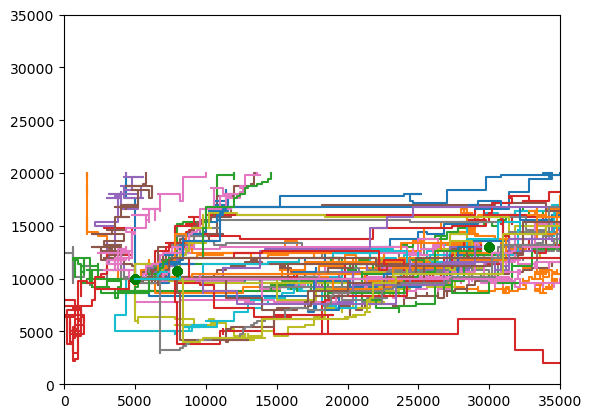

Iteration 1: 100%|██████████| 100/100 [01:02<00:00,  1.79it/s, episode=200, return=1834.499] 

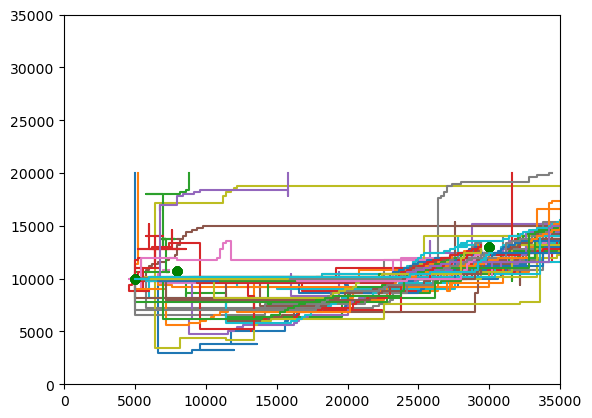

Iteration 2: 100%|██████████| 100/100 [01:03<00:00,  2.19it/s, episode=300, return=13913.708]

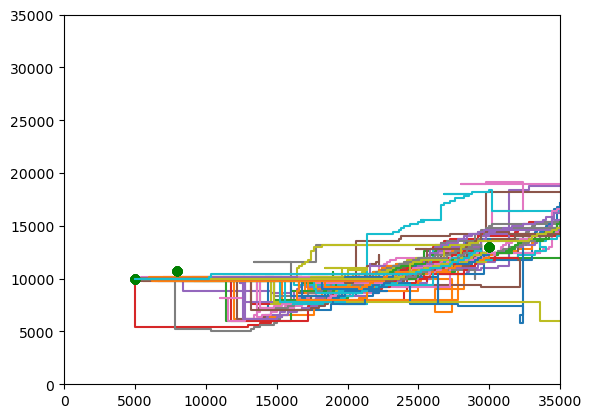

Iteration 3: 100%|██████████| 100/100 [00:57<00:00,  1.69it/s, episode=400, return=-14314.790]

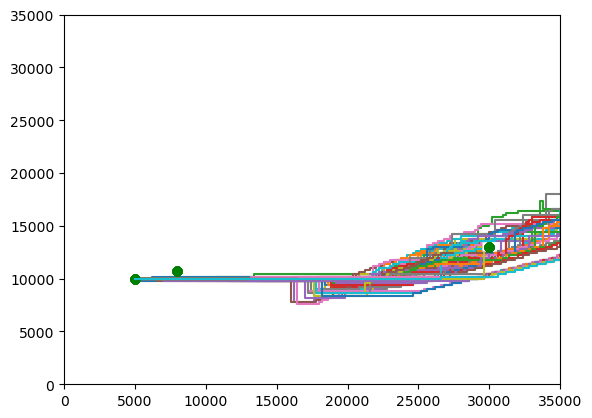

Iteration 4: 100%|██████████| 100/100 [00:57<00:00,  1.39it/s, episode=500, return=-5829.404]

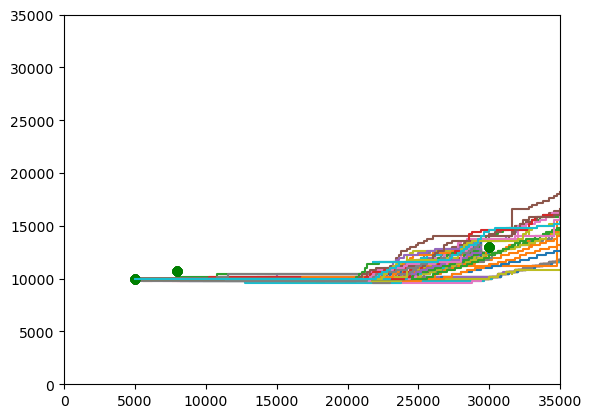

Iteration 5: 100%|██████████| 100/100 [00:54<00:00,  1.83it/s, episode=600, return=-3950.537]

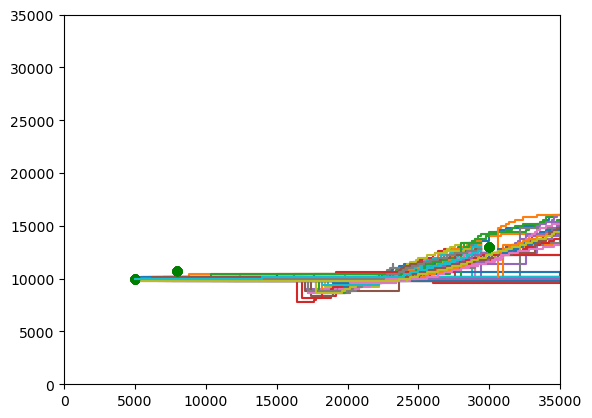

Iteration 6: 100%|██████████| 100/100 [00:55<00:00,  3.66it/s, episode=700, return=-15737.056]

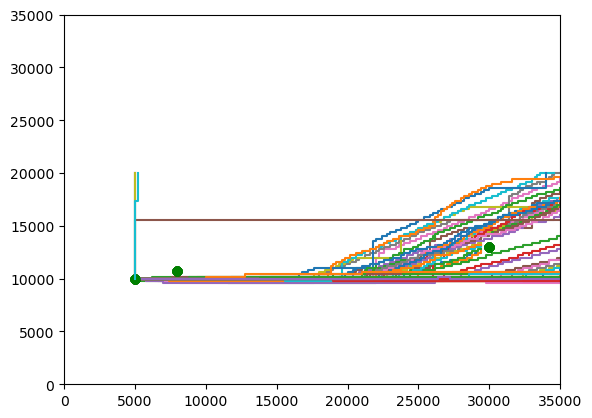

Iteration 7: 100%|██████████| 100/100 [00:54<00:00,  1.86it/s, episode=800, return=-15999.633]

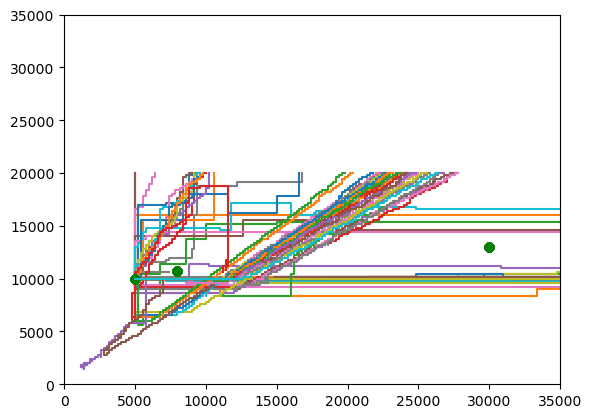

Iteration 8: 100%|██████████| 100/100 [01:04<00:00,  1.61it/s, episode=900, return=3546.138] 

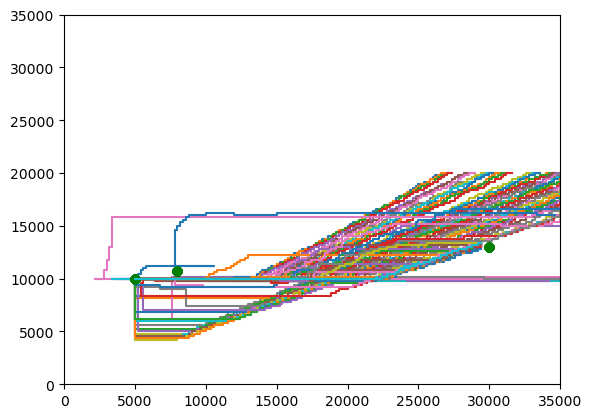

Iteration 9: 100%|██████████| 100/100 [00:56<00:00,  1.75it/s, episode=1000, return=-20707.539]

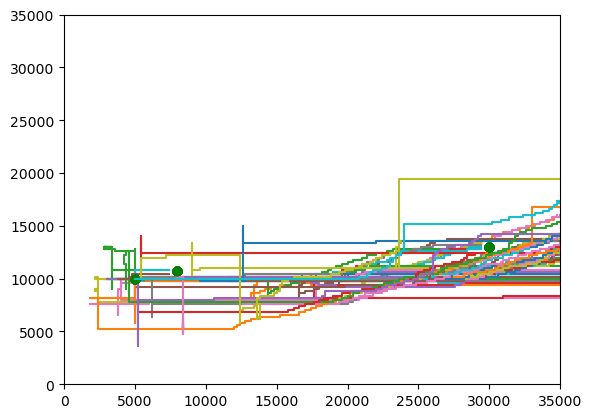

Iteration 9: 100%|██████████| 100/100 [00:57<00:00,  1.75it/s, episode=1000, return=-20707.539]


In [11]:
lr = 2e-3
num_episodes = 1000
hidden_dim = 128
gamma = 0.98
epsilon = 0.01
target_update = 10
buffer_size = 10000
minimal_size = 500
batch_size = 64
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

random.seed(0)
np.random.seed(0)
#env.seed(0)
torch.manual_seed(0)
replay_buffer = ReplayBuffer(buffer_size)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
#print(env.observation_space)
#print(env.action_space)
agent = DQN(state_dim, hidden_dim, action_dim, lr, gamma, epsilon,
            target_update, device)

return_list = []
for i in range(10):
    with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            state = env.reset()
            done = False
            #绘制x,y轴
            X=[]
            Y=[]
            count = 0
            while not done:
                X.append(state[0])
                Y.append(state[1])
                count+=1
                action = agent.take_action(state)
                next_state, reward, done, _ = env.step(action)
                replay_buffer.add(state, action, reward, next_state, done)
                state = next_state
                episode_return += reward
                # 当buffer数据的数量超过一定值后,才进行Q网络训练
                if replay_buffer.size() > minimal_size:
                    b_s, b_a, b_r, b_ns, b_d = replay_buffer.sample(batch_size)
                    transition_dict = {
                        'states': b_s,
                        'actions': b_a,
                        'next_states': b_ns,
                        'rewards': b_r,
                        'dones': b_d
                    }
                    agent.update(transition_dict)
                if (count>500):
                    done = True
            #画图可视化
            plt.plot(5000, 10000, 'go')  # 'ro'表示红色的点
            plt.plot(30000, 13000, 'go')  # 'ro'表示红色的点
            plt.plot(8000, 10700, 'go')  # 'ro'表示红色的点
            #plt.plot(50, 50, 'ro',markersize=env.r_obstacles)#障碍物
            plt.xlim(0, 35000)
            plt.ylim(0, 35000)
            plt.plot(X,Y)
            return_list.append(episode_return)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)
        plt.show()

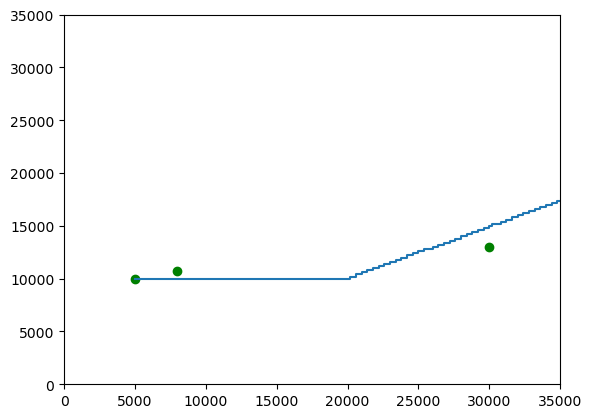

In [12]:
state = env.reset()
done = False
 #绘制x,y轴
X=[]
Y=[]
while not done:
    X.append(state[0])
    Y.append(state[1])
    action = agent.take_action(state)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.add(state, action, reward, next_state, done)
    state = next_state

 #画图可视化
plt.plot(5000, 10000, 'go')  # 'ro'表示红色的点
plt.plot(30000, 13000, 'go')  # 'ro'表示红色的点
plt.plot(8000, 10700, 'go')  # 'ro'表示红色的点
#plt.plot(50, 50, 'ro',markersize=env.r_obstacles)#障碍物
plt.xlim(0, 35000)
plt.ylim(0, 35000)
plt.plot(X,Y)

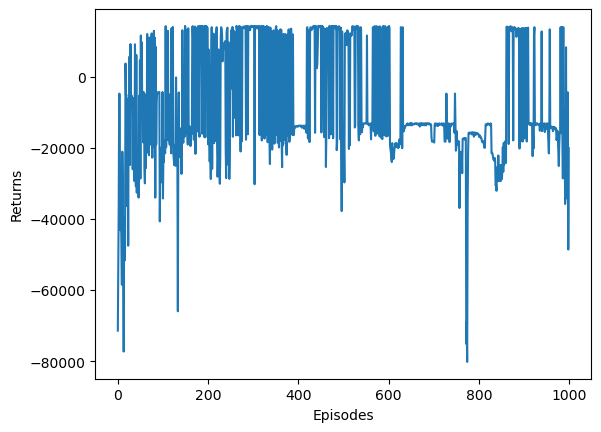

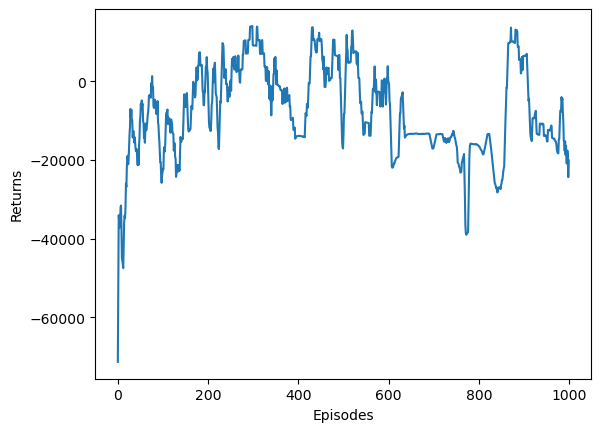

In [15]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('DQN on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
#plt.title('DQN on {}'.format(env_name))
plt.show()

In [8]:
class ConvolutionalQnet(torch.nn.Module):
    ''' 加入卷积层的Q网络 '''
    def __init__(self, action_dim, in_channels=4):
        super(ConvolutionalQnet, self).__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, 32, kernel_size=8, stride=4)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 64, kernel_size=3, stride=1)
        self.fc4 = torch.nn.Linear(7 * 7 * 64, 512)
        self.head = torch.nn.Linear(512, action_dim)

    def forward(self, x):
        x = x / 255
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.fc4(x))
        return self.head(x)